In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [42]:
datapath = "../data/ICPSR_04351/DS0002/04351-0002-Data.csv"

dump = pd.read_csv(datapath)


unemployment_datapath = "../data/ECONOMIC/UNRATE.csv"
unemployment = pd.read_csv(unemployment_datapath)

In [43]:
dump = dump[["MONTH","YEAR", "VICSEX", "VICRACE", "OFFSEX", "OFFRACE", "RELATION", "CIRCUM", "POPGROUP", "STCODE"]]

# use date for joining
dump['DATE'] = pd.to_datetime(dump[['YEAR', 'MONTH']].assign(DAY=1)).dt.date 

dump["DATE_and_STATE"] = dump["DATE"].astype(str) + "_" + dump["STCODE"].astype(str)

dump["COUNT"] = 1

dump["IN_FAMILY"] = dump["RELATION"].apply(lambda x: 1 if 1 <= 1 and x <= 16 else 0)
dump["KILLED_CHILD"] = dump["RELATION"].apply(lambda x: 1 if x in [7,8] else 0)
dump["IN_CITY"] = dump["POPGROUP"].apply(lambda x: 1 if x in [1, 2, 10, 11, 12, 13, 20] else 0)
dump["IN_SUBURB"] = dump["POPGROUP"].apply(lambda x: 1 if x in [3, 4, 5, 30, 40, 50] else 0)
dump["IN_RURAL"] = dump["POPGROUP"].apply(lambda x: 1 if x not in [1, 2, 10, 11, 12, 13, 20, 3, 4, 5, 30, 40, 50] else 0)

# drop unknown race and unknown sex for offender
dump = dump[dump['OFFSEX'] != 9]
dump = dump[dump['OFFRACE'] != 9]

# Collapse Race into white, non white; collapse sex into male
dump['WHITE_OFF'] = dump['OFFRACE'].apply(lambda x : 1 if x == 1 else 0)
dump['MALE_OFF'] = dump['OFFSEX'].apply(lambda x: 1 if x == 1 else 0)


# D_S_PANEL = dump.groupby("DATE_and_STATE")[["COUNT","IN_FAMILY", "KILLED_CHILD", "IN_CITY", "IN_SUBURB", "IN_RURAL"]].sum()


In [44]:
# new granuality of data

# Cole's group by


# what we want to keep
groupby_cols = ["DATE", "IN_FAMILY", "KILLED_CHILD", "IN_CITY", "WHITE_OFF", "MALE_OFF", "IN_RURAL"]
# groupby_cols = ["DATE", "IN_FAMILY", ]


drop_cols = [col for col in dump.columns if col not in groupby_cols] 
print("dropped cols" , drop_cols)

ts = dump.drop(columns=drop_cols, axis=1)


# maybe try not counting
ts = ts.groupby(groupby_cols)['DATE'].agg('count').to_frame("Counts").reset_index()
ts['DATE'] = pd.to_datetime(ts['DATE'])



start_date =  pd.to_datetime("1976-01-01")

# periods
ts['start_date'] = start_date
ts['PERIOD'] = (ts['DATE'].dt.year - ts['start_date'].dt.year) * 12 + (ts['DATE'].dt.month - ts['start_date'].dt.month)
ts['PERIOD_SQ'] = ts['PERIOD'] **2
ts['LOG_PERIOD'] = np.log(ts['PERIOD'] + 1)



print(ts)


dropped cols ['MONTH', 'YEAR', 'VICSEX', 'VICRACE', 'OFFSEX', 'OFFRACE', 'RELATION', 'CIRCUM', 'POPGROUP', 'STCODE', 'DATE_and_STATE', 'COUNT', 'IN_SUBURB']
            DATE  IN_FAMILY  KILLED_CHILD  IN_CITY  WHITE_OFF  MALE_OFF  \
0     1976-01-01          0             0        0          0         0   
1     1976-01-01          0             0        0          0         0   
2     1976-01-01          0             0        0          0         1   
3     1976-01-01          0             0        0          0         1   
4     1976-01-01          0             0        0          1         0   
...          ...        ...           ...      ...        ...       ...   
11584 2003-12-01          1             1        0          1         1   
11585 2003-12-01          1             1        1          0         0   
11586 2003-12-01          1             1        1          0         1   
11587 2003-12-01          1             1        1          1         0   
11588 2003-12-01  

In [45]:

# make both dates same type before merge

unemployment['DATE'] = pd.to_datetime(unemployment['DATE'])

# add year only column for inflation merge
ts['YEAR'] = ts['DATE'].dt.year


In [46]:
# inflation data
inflation_df = pd.read_csv('../data/ECONOMIC/FPCPITOTLZGUSA.csv')
inflation_df['DATE'] = pd.to_datetime(inflation_df['DATE'])
inflation_df['YEAR'] = inflation_df['DATE'].dt.year
inflation_df.rename(columns={"FPCPITOTLZGUSA": "CPI"}, inplace=True)

In [47]:
population_df = pd.read_csv('../data/ECONOMIC/POPTHM.csv')
population_df['DATE'] = pd.to_datetime(population_df['DATE'])
population_df.rename(columns={"POPTHM": "POP"}, inplace=True)

In [48]:
# Merge on date
ts = ts.merge(unemployment, how="left", on='DATE')
ts = ts.merge(population_df, how='left', on='DATE')
ts = ts.merge(inflation_df[['YEAR', 'CPI']], how='left', on='YEAR')

#ts.dropna(inplace=True)
# ts2.dropna(inplace=True)

In [49]:
# use pop to get in family murder RATE  
ts['MURDERS_PER_100K'] = ts['Counts'] / (ts['POP'] / 100)

## More complicated Reg - this is our reg

In [59]:
# DON'T MODIFY ts HERE

# drop any rows that are not infamily murders
reg_data = ts[ts['IN_FAMILY'] == 1]

x = reg_data[["UNRATE", 'CPI', "WHITE_OFF", "MALE_OFF", "IN_RURAL", 'PERIOD', 'PERIOD_SQ']]
x = sm.add_constant(x)
y = ((reg_data["MURDERS_PER_100K"]))


model = sm.OLS(y, x).fit()

print(model.summary())

from statsmodels.iolib.summary2 import summary_col
res = summary_col(model, stars=True)
print(res)

# save as image
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize=(16, 8))
# summary = []
# model.summary(print_fn=lambda x: summary.append(x))
# summary = '\n'.join(summary)
# ax.text(0.01, 0.05, summary, fontfamily='monospace', fontsize=12)
# ax.axis('off')
# plt.tight_layout()
# plt.savefig('output.png', dpi=300, bbox_inches='tight')



                            OLS Regression Results                            
Dep. Variable:       MURDERS_PER_100K   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     301.6
Date:                Sun, 28 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:08:19   Log-Likelihood:                 30726.
No. Observations:                7563   AIC:                        -6.144e+04
Df Residuals:                    7555   BIC:                        -6.138e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.421      0.0

### Extra plots and figs for paper

          IN_FAMILY  KILLED_CHILD  IN_CITY  WHITE_OFF  IN_RURAL  Counts  \
MALE_OFF                                                                  
0              3719          1759     1318       1952      1222   21511   
1              3844          1828     1333       1990      1274   53835   

          PERIOD  PERIOD_SQ    LOG_PERIOD     YEAR   UNRATE          POP  \
MALE_OFF                                                                   
0         616471  136495469  17925.536704  7398410  23647.9  935652201.0   
1         644356  144021370  18579.745630  7647672  24388.2  968850245.0   

                   CPI  MURDERS_PER_100K  
MALE_OFF                                  
0         16914.096362          8.858245  
1         17383.308449         21.826360  
           IN_FAMILY  KILLED_CHILD  IN_CITY  MALE_OFF  IN_RURAL  Counts  \
WHITE_OFF                                                                 
0               3621          1644     1335      1854      1164   30323 

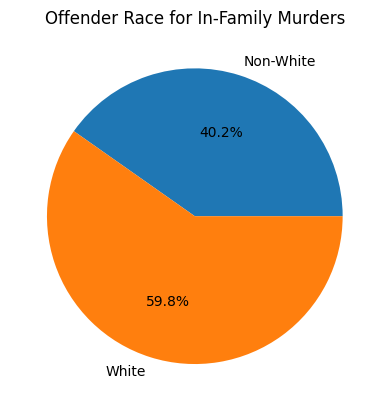

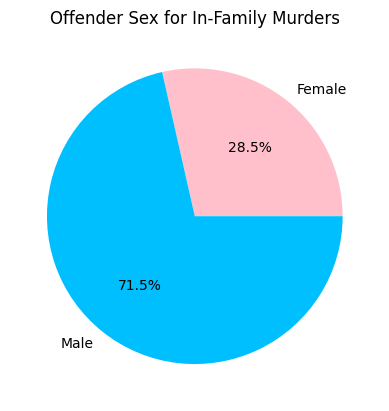

In [57]:
by_race = reg_data.groupby(['WHITE_OFF']).sum('Counts')
by_sex = reg_data.groupby(['MALE_OFF']).sum('Counts')
by_rural = reg_data.groupby(['IN_RURAL']).sum('Counts')

plt.pie(by_race['Counts'], labels=['Non-White', 'White'], normalize=True, autopct='%1.1f%%')
plt.title("Offender Race for In-Family Murders")
plt.show()


plt.pie(by_sex['Counts'], labels=['Female', 'Male'], normalize=True, autopct='%1.1f%%', colors=['Pink', 'deepskyblue'])
plt.title("Offender Sex for In-Family Murders")
plt.show()